In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import timm

from tqdm import tqdm

# constants

In [2]:
DEVICE = "mps"
PATH = "../../data/"

In [3]:
plt.style.use("seaborn")

/var/folders/ck/dprw6n6j021bpgf2bbls593h0000gn/T/ipykernel_5250/1490283864.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# data

In [4]:
with open(PATH+"train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [5]:
with open(PATH+"valid.pkl", "rb") as f:
    X_valid, y_valid = pickle.load(f)

# eda

In [6]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1622, 256, 256, 3), (1622, 6), (1751, 256, 256, 3), (1751, 6))

In [7]:
y_train = y_train["lymphocyte"].values
y_valid = y_valid["lymphocyte"].values

(<matplotlib.image.AxesImage at 0x172363bd0>, 4)

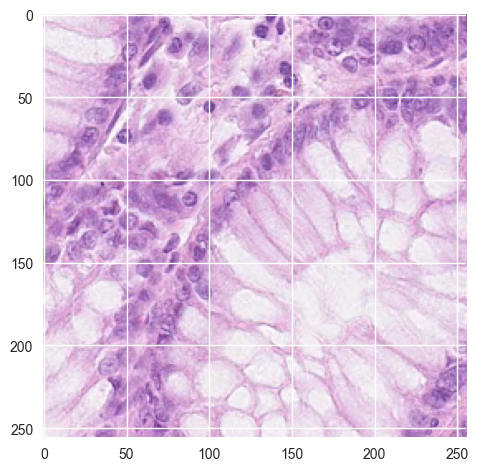

In [8]:
plt.imshow(X_train[0]), y_train[0]

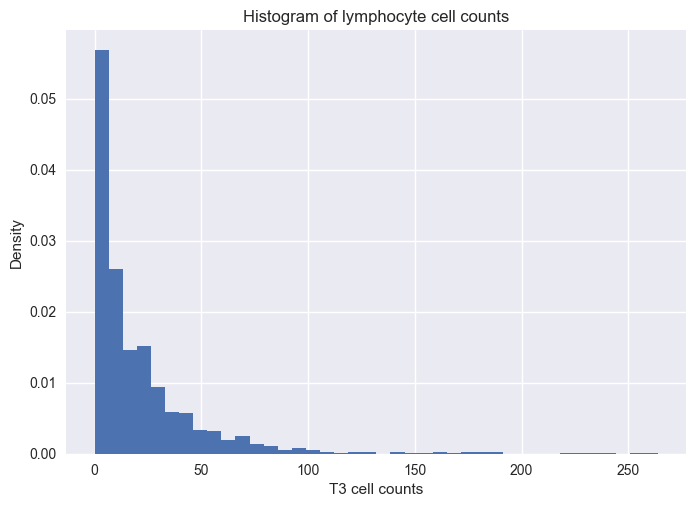

In [9]:
plt.title("Histogram of lymphocyte cell counts")
plt.hist(y_train,bins=40,density=True)
plt.ylabel("Density")
plt.xlabel("T3 cell counts")
plt.show()

In [10]:
# overdispersion
np.mean(y_train), np.std(y_train)

(20.73736128236745, 28.74817440090567)

# ResNet18, ImageNet pretraining, linear head

## Model definition

In [15]:
model = timm.create_model("resnet18",pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [16]:
model.default_cfg

{'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet18'}

In [17]:
class r18(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = timm.create_model("resnet18",pretrained=True)
        self.base_model.fc = nn.Identity()
        self.head = nn.Sequential(
            nn.Linear(512,1, bias=True),
        )
    def forward(self,x):
        out = self.base_model(x)
        out = self.head(out)
        return out
    
model = r18().to(device=DEVICE)

for param in model.parameters():
    param.requires_grad = True 

## dataset

In [18]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, X_transforms=None, y_transforms=None, isTrain=True):
        """
        X: numpy array of dimension (N, H, W, C)
        y: numpy array of dimension (N, 1)
        X_transforms is a torchvision transforms Compose object
        y_transforms is an sklearn transformer
        isTrain is a boolean
        """
        self.X = X
        self.y = y.reshape(-1,1)
        self.X_transforms = X_transforms 
        self.y_transforms = y_transforms
        self.isTrain = isTrain

        if self.y_transforms:
            if isTrain:
                self.y_preprocessed = self.y_transforms.fit_transform(self.y)
            else:
                self.y_preprocessed = self.y_transforms.transform(self.y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        if self.X_transforms:
            # this will return a tensor
            img = self.X_transforms(self.X[idx]).float()
        else:
            # else convert to floating point tensor
            img = np.moveaxis(self.X[idx],-1,0)
            img = torch.Tensor(self.X[idx]).float()
        if self.y_transforms:
            lbl = torch.Tensor(self.y_preprocessed[idx]).float()
        else:
            lbl = torch.Tensor(self.y[idx]).float()
        return img, lbl

In [19]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])
valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [20]:
train_dataset = dataset(X=X_train,y=y_train,X_transforms=train_transforms)
valid_dataset = dataset(X=X_valid,y=y_valid,X_transforms=valid_transforms)

## Dataloaders

In [21]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
train_loader_validate = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=BATCH_SIZE, shuffle=False)

## Setup

In [22]:
optim = torch.optim.Adam(params=model.parameters(),lr=3e-4,weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim,factor=0.1,patience=3,threshold=0)

In [23]:
loss_func = nn.MSELoss(reduction="sum")

# Training

In [24]:
N_EPOCHS=100
training_losses = []
validation_losses = []

for epoch in tqdm(range(N_EPOCHS)):
    # train
    model.train()
    for idx, (imgs,labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device=DEVICE), labels.to(device=DEVICE)
        optim.zero_grad()
        preds = model(imgs)
        loss = torch.sqrt(loss_func(preds,labels))
        loss.backward()
        optim.step()
    # At the end of an epoch, get training and validation statistics
    model.eval()
    with torch.no_grad():
        # Training
        total_loss = 0
        for idx, (imgs,labels) in enumerate(train_loader_validate):
            imgs, labels = imgs.to(device=DEVICE), labels.to(device=DEVICE)
            preds = model(imgs)
            loss = torch.sqrt(loss_func(preds,labels))
            total_loss += loss.cpu().item()
        training_losses.append(total_loss/(len(X_train)))
        # Validation
        total_loss = 0
        for idx, (imgs,labels) in enumerate(valid_loader):
            imgs, labels = imgs.to(device=DEVICE), labels.to(device=DEVICE)
            preds = model(imgs)
            loss = torch.sqrt(loss_func(preds,labels))
            total_loss += loss.cpu().item()
        validation_losses.append(total_loss/(len(X_valid)))
    print(f"Epoch {epoch+1}: training loss = {training_losses[-1]}, validation loss = {validation_losses[-1]}")

  1%|          | 1/100 [00:08<13:39,  8.28s/it]

Epoch 1: training loss = 1.5764879163184677, validation loss = 1.870165944167507


  2%|▏         | 2/100 [00:16<13:26,  8.23s/it]

Epoch 2: training loss = 1.5066056727775075, validation loss = 1.781670204916387


  3%|▎         | 3/100 [00:25<13:41,  8.47s/it]

Epoch 3: training loss = 1.2300154078021444, validation loss = 1.6611450561314294


  4%|▍         | 4/100 [00:33<13:32,  8.46s/it]

Epoch 4: training loss = 1.3607763062276028, validation loss = 1.7434491517542432


  5%|▌         | 5/100 [00:42<13:19,  8.42s/it]

Epoch 5: training loss = 1.318702481383901, validation loss = 1.6682884089950831


  6%|▌         | 6/100 [00:50<13:09,  8.40s/it]

Epoch 6: training loss = 1.226184529823087, validation loss = 1.661353267580356


  7%|▋         | 7/100 [00:58<13:00,  8.39s/it]

Epoch 7: training loss = 1.22692778901313, validation loss = 1.6180768407868495


  8%|▊         | 8/100 [01:07<12:52,  8.40s/it]

Epoch 8: training loss = 1.140119023446531, validation loss = 1.5917201801955803


  9%|▉         | 9/100 [01:15<12:44,  8.40s/it]

Epoch 9: training loss = 1.1250282127672, validation loss = 1.58146947210411


 10%|█         | 10/100 [01:23<12:35,  8.39s/it]

Epoch 10: training loss = 0.8338359498801272, validation loss = 1.3610855268111302


 11%|█         | 11/100 [01:32<12:34,  8.48s/it]

Epoch 11: training loss = 0.5998986758080422, validation loss = 1.202047037574511


 12%|█▏        | 12/100 [01:41<12:24,  8.46s/it]

Epoch 12: training loss = 0.47663510624783256, validation loss = 1.0547318297886699


 13%|█▎        | 13/100 [01:49<12:14,  8.44s/it]

Epoch 13: training loss = 0.6690294051728913, validation loss = 1.2223415930294297


 14%|█▍        | 14/100 [01:57<12:07,  8.46s/it]

Epoch 14: training loss = 0.46705004201717354, validation loss = 0.8730373720248585


 15%|█▌        | 15/100 [02:06<12:04,  8.52s/it]

Epoch 15: training loss = 0.5003201782188933, validation loss = 1.056329593190052


 16%|█▌        | 16/100 [02:15<11:55,  8.51s/it]

Epoch 16: training loss = 0.32353444575675466, validation loss = 1.0035323573819983


 17%|█▋        | 17/100 [02:23<11:47,  8.53s/it]

Epoch 17: training loss = 0.6154957970032415, validation loss = 0.8661444471741594


 18%|█▊        | 18/100 [02:32<11:45,  8.60s/it]

Epoch 18: training loss = 0.6119430156289135, validation loss = 1.102997532032477


 19%|█▉        | 19/100 [02:40<11:29,  8.52s/it]

Epoch 19: training loss = 0.6319156533839817, validation loss = 1.1493732968716537


 20%|██        | 20/100 [02:48<11:12,  8.40s/it]

Epoch 20: training loss = 0.3026554399295153, validation loss = 0.9493747626216938


 21%|██        | 21/100 [02:57<10:57,  8.32s/it]

Epoch 21: training loss = 0.3335336221866631, validation loss = 0.9619423317813928


 22%|██▏       | 22/100 [03:05<10:47,  8.30s/it]

Epoch 22: training loss = 0.3130975739729537, validation loss = 0.8852049142956258


 23%|██▎       | 23/100 [03:13<10:37,  8.28s/it]

Epoch 23: training loss = 0.18065721862266154, validation loss = 0.8451545057400236


 24%|██▍       | 24/100 [03:21<10:28,  8.27s/it]

Epoch 24: training loss = 0.21448587636324393, validation loss = 0.8820939469786796


 25%|██▌       | 25/100 [03:30<10:20,  8.27s/it]

Epoch 25: training loss = 0.16096541149548627, validation loss = 0.9079032083159512


 26%|██▌       | 26/100 [03:38<10:18,  8.36s/it]

Epoch 26: training loss = 0.15967808522366714, validation loss = 0.8141647896584207


 27%|██▋       | 27/100 [03:46<10:09,  8.35s/it]

Epoch 27: training loss = 0.12930129400457907, validation loss = 0.8682572273851326


 28%|██▊       | 28/100 [03:55<09:59,  8.32s/it]

Epoch 28: training loss = 0.1452470584215571, validation loss = 0.9052193694493214


 29%|██▉       | 29/100 [04:03<09:49,  8.30s/it]

Epoch 29: training loss = 0.14204843594025449, validation loss = 0.8594881250543774


 30%|███       | 30/100 [04:11<09:43,  8.34s/it]

Epoch 30: training loss = 0.2152735748949533, validation loss = 0.8718301848232372


 31%|███       | 31/100 [04:20<09:33,  8.31s/it]

Epoch 31: training loss = 0.281446991954573, validation loss = 0.8244711256653564


 32%|███▏      | 32/100 [04:28<09:25,  8.32s/it]

Epoch 32: training loss = 0.2042654498437771, validation loss = 0.8691952464105333


 33%|███▎      | 33/100 [04:37<09:26,  8.45s/it]

Epoch 33: training loss = 0.14335680360711753, validation loss = 0.9306589254033967


 34%|███▍      | 34/100 [04:46<09:26,  8.59s/it]

Epoch 34: training loss = 0.4566529482125354, validation loss = 1.1073826038789776


 35%|███▌      | 35/100 [04:54<09:23,  8.67s/it]

Epoch 35: training loss = 0.21466799523180716, validation loss = 0.8365815847278117


 36%|███▌      | 36/100 [05:04<09:23,  8.80s/it]

Epoch 36: training loss = 0.28879626729191454, validation loss = 0.9493354000002231


 37%|███▋      | 37/100 [05:13<09:20,  8.89s/it]

Epoch 37: training loss = 0.3318394779718025, validation loss = 0.9164998497301208


 38%|███▊      | 38/100 [05:22<09:13,  8.94s/it]

Epoch 38: training loss = 0.1757442860068287, validation loss = 0.8234499850183266


 39%|███▉      | 39/100 [05:31<09:09,  9.00s/it]

Epoch 39: training loss = 0.18521609935454758, validation loss = 0.8874700601818493


 40%|████      | 40/100 [05:40<09:08,  9.14s/it]

Epoch 40: training loss = 0.18862399984376205, validation loss = 0.8781562164672643


 41%|████      | 41/100 [05:50<09:03,  9.22s/it]

Epoch 41: training loss = 0.176852270942434, validation loss = 0.8542239561140844


 42%|████▏     | 42/100 [05:59<08:56,  9.25s/it]

Epoch 42: training loss = 0.15336048794145501, validation loss = 0.8964477966064592


 43%|████▎     | 43/100 [06:08<08:48,  9.27s/it]

Epoch 43: training loss = 0.12112887602405101, validation loss = 0.854332663003953


 44%|████▍     | 44/100 [06:18<08:40,  9.29s/it]

Epoch 44: training loss = 0.18270352265984738, validation loss = 0.8707033001580012


 45%|████▌     | 45/100 [06:27<08:31,  9.30s/it]

Epoch 45: training loss = 0.14559699927540506, validation loss = 0.8963018446769256


 46%|████▌     | 46/100 [06:36<08:21,  9.29s/it]

Epoch 46: training loss = 0.17755690691062467, validation loss = 0.8388644512008763


 47%|████▋     | 47/100 [06:45<08:10,  9.25s/it]

Epoch 47: training loss = 0.1958003026489559, validation loss = 0.965882572019393


 48%|████▊     | 48/100 [06:55<07:59,  9.23s/it]

Epoch 48: training loss = 0.11710990901058023, validation loss = 0.9190975387459956


 49%|████▉     | 49/100 [07:04<07:48,  9.18s/it]

Epoch 49: training loss = 0.10399448709923007, validation loss = 0.8839885073345365


 50%|█████     | 50/100 [07:13<07:38,  9.17s/it]

Epoch 50: training loss = 0.19457589065984499, validation loss = 0.9277210028630403


 51%|█████     | 51/100 [07:22<07:33,  9.25s/it]

Epoch 51: training loss = 0.1639114513938142, validation loss = 0.8327473717236914


 52%|█████▏    | 52/100 [07:32<07:34,  9.47s/it]

Epoch 52: training loss = 0.11769392281660464, validation loss = 0.8319087134709295


 53%|█████▎    | 53/100 [07:42<07:26,  9.50s/it]

Epoch 53: training loss = 0.1453108287768946, validation loss = 0.9006068579882366


 54%|█████▍    | 54/100 [07:51<07:15,  9.47s/it]

Epoch 54: training loss = 0.1947197720096085, validation loss = 0.9199885483267374


 55%|█████▌    | 55/100 [08:01<07:05,  9.45s/it]

Epoch 55: training loss = 0.1813529504947686, validation loss = 0.9164624783326938


 56%|█████▌    | 56/100 [08:10<06:52,  9.39s/it]

Epoch 56: training loss = 0.2343985808027952, validation loss = 0.96416941348108


 57%|█████▋    | 57/100 [08:19<06:40,  9.30s/it]

Epoch 57: training loss = 0.2199622329448507, validation loss = 0.9148091088016669


 58%|█████▊    | 58/100 [08:28<06:30,  9.31s/it]

Epoch 58: training loss = 0.2424494417616236, validation loss = 0.8645608140563094


 59%|█████▉    | 59/100 [08:38<06:24,  9.38s/it]

Epoch 59: training loss = 0.11185491011557244, validation loss = 0.8415225435841908


 60%|██████    | 60/100 [08:47<06:15,  9.39s/it]

Epoch 60: training loss = 0.07919030947985102, validation loss = 0.868865073578212


 61%|██████    | 61/100 [08:56<05:59,  9.23s/it]

Epoch 61: training loss = 0.1254083184219906, validation loss = 0.9257598998953723


 62%|██████▏   | 62/100 [09:05<05:45,  9.09s/it]

Epoch 62: training loss = 0.107820306841454, validation loss = 0.9049913764748827


 63%|██████▎   | 63/100 [09:13<05:29,  8.90s/it]

Epoch 63: training loss = 0.23747402642716903, validation loss = 0.9643854852542408


 64%|██████▍   | 64/100 [09:22<05:13,  8.72s/it]

Epoch 64: training loss = 0.10578593314061477, validation loss = 0.8929545796305571


 65%|██████▌   | 65/100 [09:30<05:00,  8.57s/it]

Epoch 65: training loss = 0.11781900408235636, validation loss = 0.8983185581314026


 66%|██████▌   | 66/100 [09:38<04:47,  8.47s/it]

Epoch 66: training loss = 0.12263872591105696, validation loss = 0.8796919904934346


 67%|██████▋   | 67/100 [09:46<04:38,  8.45s/it]

Epoch 67: training loss = 0.17842467175165028, validation loss = 0.8343489476437571


 68%|██████▊   | 68/100 [09:55<04:31,  8.48s/it]

Epoch 68: training loss = 0.21738807311334388, validation loss = 0.9631066227013693


 69%|██████▉   | 69/100 [10:04<04:23,  8.49s/it]

Epoch 69: training loss = 0.23356492010791557, validation loss = 0.9507144468297691


 70%|███████   | 70/100 [10:12<04:14,  8.49s/it]

Epoch 70: training loss = 0.2042739894034389, validation loss = 0.830453808412492


 71%|███████   | 71/100 [10:21<04:07,  8.52s/it]

Epoch 71: training loss = 0.26063917068312115, validation loss = 0.987741924571283


 72%|███████▏  | 72/100 [10:29<03:58,  8.51s/it]

Epoch 72: training loss = 0.1765266581910459, validation loss = 0.8236239142992509


 73%|███████▎  | 73/100 [10:37<03:46,  8.40s/it]

Epoch 73: training loss = 0.1917399560479142, validation loss = 0.9486666580801484


 74%|███████▍  | 74/100 [10:46<03:38,  8.41s/it]

Epoch 74: training loss = 0.13317197583312612, validation loss = 0.8605488461810885


 75%|███████▌  | 75/100 [10:54<03:32,  8.48s/it]

Epoch 75: training loss = 0.08781789939588742, validation loss = 0.8654774611912612


 76%|███████▌  | 76/100 [11:03<03:24,  8.52s/it]

Epoch 76: training loss = 0.12910370703249177, validation loss = 0.9064587560944527


 77%|███████▋  | 77/100 [11:11<03:15,  8.52s/it]

Epoch 77: training loss = 0.09233374131152133, validation loss = 0.888301633685606


 78%|███████▊  | 78/100 [11:20<03:08,  8.56s/it]

Epoch 78: training loss = 0.09344928626214531, validation loss = 0.8931009934194969


 79%|███████▉  | 79/100 [11:29<03:01,  8.64s/it]

Epoch 79: training loss = 0.16148650102344894, validation loss = 0.9266375634821397


 80%|████████  | 80/100 [11:38<02:54,  8.70s/it]

Epoch 80: training loss = 0.27410639846369017, validation loss = 0.9775404306495619


 81%|████████  | 81/100 [11:46<02:44,  8.64s/it]

Epoch 81: training loss = 0.1435137124302649, validation loss = 0.858380237625096


 82%|████████▏ | 82/100 [11:55<02:34,  8.59s/it]

Epoch 82: training loss = 0.16142944284196847, validation loss = 0.8771158607260695


 83%|████████▎ | 83/100 [12:03<02:25,  8.55s/it]

Epoch 83: training loss = 0.11843206732546505, validation loss = 0.8930528336834866


 84%|████████▍ | 84/100 [12:12<02:16,  8.56s/it]

Epoch 84: training loss = 0.18793400824437453, validation loss = 0.8348778245926992


 85%|████████▌ | 85/100 [12:20<02:08,  8.59s/it]

Epoch 85: training loss = 0.14964663908896111, validation loss = 0.9403573019309837


 86%|████████▌ | 86/100 [12:29<01:59,  8.56s/it]

Epoch 86: training loss = 0.12432251082395655, validation loss = 0.8645607225558609


 87%|████████▋ | 87/100 [12:38<01:51,  8.56s/it]

Epoch 87: training loss = 0.1934696472675968, validation loss = 0.883381593574598


 88%|████████▊ | 88/100 [12:46<01:42,  8.53s/it]

Epoch 88: training loss = 0.12331715523829148, validation loss = 0.8538697840212959


 89%|████████▉ | 89/100 [12:55<01:34,  8.56s/it]

Epoch 89: training loss = 0.22106245795836724, validation loss = 0.9869370648412961


 90%|█████████ | 90/100 [13:03<01:25,  8.54s/it]

Epoch 90: training loss = 0.19980060422170617, validation loss = 0.8367072192006354


 91%|█████████ | 91/100 [13:12<01:16,  8.52s/it]

Epoch 91: training loss = 0.17470305886133383, validation loss = 0.9345856148607046


 92%|█████████▏| 92/100 [13:20<01:08,  8.52s/it]

Epoch 92: training loss = 0.2617817230789053, validation loss = 0.9907319326526025


 93%|█████████▎| 93/100 [13:29<00:59,  8.50s/it]

Epoch 93: training loss = 0.18527468858899965, validation loss = 0.8731999247500313


 94%|█████████▍| 94/100 [13:37<00:51,  8.58s/it]

Epoch 94: training loss = 0.1304989108028012, validation loss = 0.9102651050334518


 95%|█████████▌| 95/100 [13:46<00:43,  8.62s/it]

Epoch 95: training loss = 0.14601683940017268, validation loss = 0.9205678594514072


 96%|█████████▌| 96/100 [13:55<00:34,  8.65s/it]

Epoch 96: training loss = 0.18501297613254458, validation loss = 0.8742755822356533


 97%|█████████▋| 97/100 [14:03<00:25,  8.62s/it]

Epoch 97: training loss = 0.17947449254930828, validation loss = 0.9120081014322731


 98%|█████████▊| 98/100 [14:12<00:17,  8.56s/it]

Epoch 98: training loss = 0.10684633490189671, validation loss = 0.8812298559584255


 99%|█████████▉| 99/100 [14:20<00:08,  8.56s/it]

Epoch 99: training loss = 0.164275602112569, validation loss = 0.9375351143863663


100%|██████████| 100/100 [14:29<00:00,  8.69s/it]

Epoch 100: training loss = 0.18601933184152172, validation loss = 0.8267410426463896


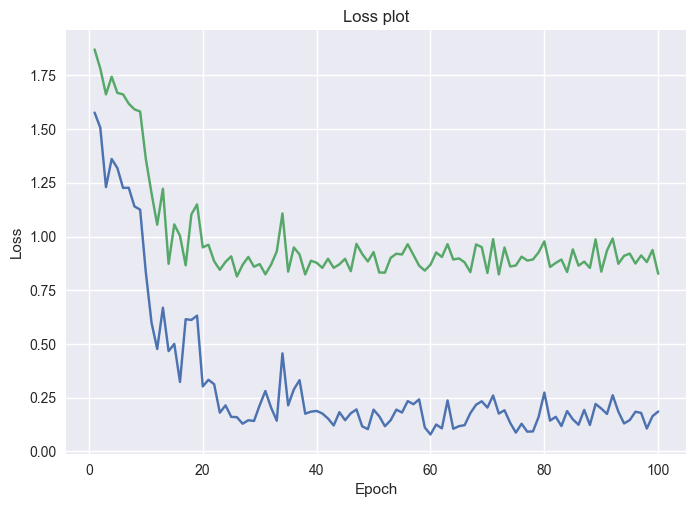

In [25]:
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot([i+1 for i in range(len(training_losses))],training_losses)
plt.plot([i+1 for i in range(len(validation_losses))],validation_losses)
plt.show()

In [26]:
train_preds = []
valid_preds = []

model.eval()
with torch.no_grad():
    for idx, (imgs,labels) in enumerate(train_loader_validate):
        imgs, labels = imgs.to(device=DEVICE), labels.to(device=DEVICE)
        preds = model(imgs)
        train_preds.extend(list(preds.cpu().numpy().reshape(-1)))
    for idx, (imgs,labels) in enumerate(valid_loader):
        imgs, labels = imgs.to(device=DEVICE), labels.to(device=DEVICE)
        preds = model(imgs)
        valid_preds.extend(list(preds.cpu().numpy().reshape(-1)))

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
np.sqrt(mean_squared_error(y_train,train_preds)), np.sqrt(mean_squared_error(y_valid,valid_preds))

(3.3803114444265514, 14.526223206165184)